# EDA IBM stock 1min ticks

## Takeouts -  december 29/2019
* The distribution of the difference of the time series has very long tails: see plot. This was expected; still very ugly.
* Created a very clean dataset with 'pastValues', 'currentValue', 'futureValue', 'deltaMinutes'. 
* The precision recall curve that we already have looks quite good: we trained one single time.

## Takeouts -  december 30/2019
* Plot a precision recall curve with several(monthly/weekly) training batches

## To do

* There is a delicate issue about rescaling before training that needs to be fixed asap.
* Turn the code that produces the 'clean' data set into a more reusable one
* The current version of the target is not very realistic.
* Need a more elaborated way of looking at histograms: the tails don't let me see anything: those tails are a huge concern.
* Look out for sklearn methods to do crossvalidation in our setting: do not reinvent the wheel.

## Questions to Jake:
* Data provider (currently using sample (adjusted) data from Kibot): he uses polygon
* How can I authomatize making orders, is there an api? how does this even work in real life? he mentioned 'efficient frontier'
* Cost per order (0.5 cents per share or 2 dollars per trade)
* Latency issues to be aware of.
* How/at what point can we know if we are `moving the market` too much? In the afternoon there is very little volume.


## Notes from Jake
* Tick data might be more useful for quant analysis.
* polygon.io source of data.
* thinkorswim.com: 2 dollars per trade, 
* interactivebrokers : half a cent per share.
* kelly criterion?
* ibridgepy ... take quantopian to real life.
* zipline - quantopian type of thing.
* efficient frontier. for blending the strategies.
* kygo: his thing.
* Use quantopian!

In [1]:
cd ~/Desktop/MyProjects/moneyManager/

/Users/lduque/Desktop/MyProjects/moneyManager


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [7]:
# only loading some rows
names = ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume']
df = pd.read_csv('data/sampleKibotData/minuteIntraday/IBM_adjusted.txt', header=None, names=names, nrows=3000)
df['DateTime'] = df.Date+' '+df.Time
df.DateTime = pd.to_datetime(df.DateTime,infer_datetime_format=True) 
ds = df.drop(columns=['Date', 'Time'])

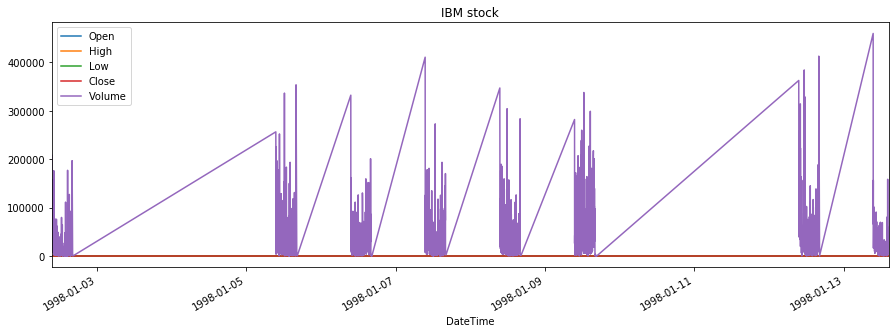

In [9]:
ds.set_index('DateTime').plot(figsize=(15,5), title='IBM stock');

In [47]:
ds.head()

,Open,High,Low,Close,Volume,DateTime
0,33.69,33.69,33.69,33.69,207820,1998-01-02 09:30:00
1,33.65,33.69,33.65,33.65,33499,1998-01-02 09:31:00
2,33.67,33.69,33.65,33.69,41254,1998-01-02 09:32:00
3,33.67,33.69,33.65,33.65,52110,1998-01-02 09:33:00
4,33.65,33.69,33.65,33.65,14892,1998-01-02 09:34:00


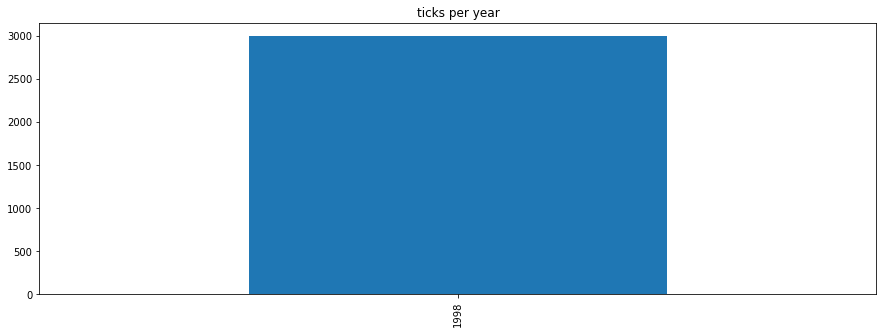

In [10]:
ds.DateTime.apply(lambda x: x.year).value_counts().sort_index().plot.bar(figsize=(15, 5), title='ticks per year');

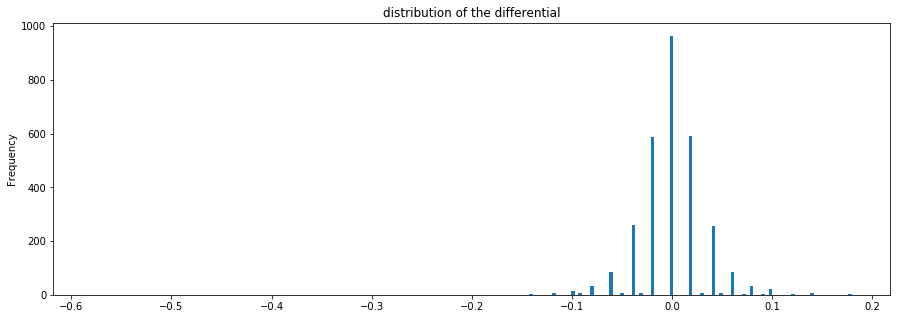

In [11]:
ds.Open.diff().plot.hist(bins=200, figsize=(15,5), title= 'distribution of the differential');

In [97]:
def pivotTimeSeries(ds):
    pastWindow = 5
    futureWindow = 10
    
    dsTimeStamp = ds.DateTime
    pastLow = pd.concat([ds.Low.shift(i) for i in range(pastWindow, 0, -1)], axis=1).apply(lambda x: list(x), axis=1)
    pastHigh = pd.concat([ds.High.shift(i) for i in range(pastWindow, 0, -1)], axis=1).apply(lambda x: list(x), axis=1)
    pastVolume = pd.concat([ds.Volume.shift(i) for i in range(pastWindow, 0, -1)], axis=1).apply(lambda x: list(x), axis=1)
    
    currentValue = ds.Close
    currentVolume = ds.Volume
    
    futureHigh = pd.concat([ds.High.shift(i) for i in range(-1, -futureWindow-1, -1)], axis=1).apply(lambda x: max(list(x)), axis=1)
    deltaMinutes = (ds.DateTime.shift(-futureWindow) - ds.DateTime.shift(pastWindow)).apply(lambda x: x.seconds)//60
    
    dg = pd.concat([dsTimeStamp, pastLow, pastHigh, pastVolume, currentValue, currentVolume, futureHigh, deltaMinutes], axis=1)
    dg.columns = ['DateTime', 'pastLow', 'pastHigh', 'pastVolume', 'currentValue', 'currentVolume', 'futureHigh', 'deltaMinutes']
    dg['target']= dg.futureHigh>dg.currentValue
    dg = dg.drop(columns='futureHigh')
    dg = dg[dg.deltaMinutes==(pastWindow+futureWindow)].drop(columns='deltaMinutes')
    dg = dg.set_index('DateTime')
    return dg

In [143]:
def produceFeatures(dg):
    # rescale pastLow, pastHigh (using currentValue), remove currentValue
    scaledPastLow = dg.apply(lambda x: np.array(x.pastLow)/x.currentValue, axis=1)
    scaledPastHigh = dg.apply(lambda x: np.array(x.pastHigh)/x.currentValue, axis=1)
    scaledPastVolume = dg.apply(lambda x: np.array(x.currentVolume)/x.currentVolume, axis=1)
    
    pastLowFeatures = scaledPastLow.apply(listToFeatures)
    pastHighFeatures = scaledPastLow.apply(listToFeatures)
    pastVolumeFeatures = scaledPastLow.apply(listToFeatures)
    
    W = (pastLowFeatures + pastHighFeatures + pastVolumeFeatures).apply(lambda x: pd.Series(x))
    
    # consider rescaling only at the very end?
    # rescale pastVolume (using currentVolume) remove currentVolume
    
    
    return W
    
    
def listToFeatures(x):
    L = list(x)
    features = [max(L), min(L), np.mean(L), np.std(L), np.median(L)] + L
    return features
    

In [144]:
produceFeatures(dg).describe()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,...,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000
mean,1.000415,0.998533,0.999464,0.000721,0.999456,0.999482,0.999472,0.999464,0.999455,0.999449,...,1.000415,0.998533,0.999464,0.000721,0.999456,0.999482,0.999472,0.999464,0.999455,0.999449
std,0.001725,0.001860,0.001695,0.000500,0.001793,0.002396,0.002185,0.001912,0.001596,0.001227,...,0.001725,0.001860,0.001695,0.000500,0.001793,0.002396,0.002185,0.001912,0.001596,0.001227
min,0.992158,0.985322,0.990151,0.000000,0.989056,0.985322,0.986554,0.987805,0.989649,0.990903,...,0.992158,0.985322,0.990151,0.000000,0.989056,0.985322,0.986554,0.987805,0.989649,0.990903
25%,0.999401,0.997637,0.998576,0.000377,0.998761,0.998215,0.998240,0.998251,0.998768,0.998804,...,0.999401,0.997637,0.998576,0.000377,0.998761,0.998215,0.998240,0.998251,0.998768,0.998804
50%,1.000000,0.998813,0.999534,0.000604,0.999414,0.999414,0.999414,0.999414,0.999413,0.999413,...,1.000000,0.998813,0.999534,0.000604,0.999414,0.999414,0.999414,0.999414,0.999413,0.999413
75%,1.001234,1.000000,1.000476,0.000932,1.000590,1.000948,1.000611,1.000601,1.000583,1.000000,...,1.001234,1.000000,1.000476,0.000932,1.000590,1.000948,1.000611,1.000601,1.000583,1.000000
max,1.007773,1.004370,1.005136,0.003833,1.005972,1.007773,1.007166,1.006569,1.006569,1.004769,...,1.007773,1.004370,1.005136,0.003833,1.005972,1.007773,1.007166,1.006569,1.006569,1.004769


In [110]:
L = [3,4,5,6]

In [114]:
np.array(L)/4

array([0.75, 1.  , 1.25, 1.5 ])

In [98]:
dg = pivotTimeSeries(ds)

In [99]:
dg.head()

,pastLow,pastHigh,pastVolume,currentValue,currentVolume,target
DateTime,,,,,,
1998-01-02 09:35:00,"[33.69, 33.65, 33.65, 33.65, 33.65]","[33.69, 33.69, 33.69, 33.69, 33.69]","[207820.0, 33499.0, 41254.0, 52110.0, 14892.0]",33.65,72272,True
1998-01-02 09:36:00,"[33.65, 33.65, 33.65, 33.65, 33.65]","[33.69, 33.69, 33.69, 33.69, 33.69]","[33499.0, 41254.0, 52110.0, 14892.0, 72272.0]",33.67,8065,True
1998-01-02 09:37:00,"[33.65, 33.65, 33.65, 33.65, 33.65]","[33.69, 33.69, 33.69, 33.69, 33.67]","[41254.0, 52110.0, 14892.0, 72272.0, 8065.0]",33.65,8685,True
1998-01-02 09:38:00,"[33.65, 33.65, 33.65, 33.65, 33.65]","[33.69, 33.69, 33.69, 33.67, 33.65]","[52110.0, 14892.0, 72272.0, 8065.0, 8685.0]",33.67,34433,True
1998-01-02 09:39:00,"[33.65, 33.65, 33.65, 33.65, 33.65]","[33.69, 33.69, 33.67, 33.65, 33.67]","[14892.0, 72272.0, 8065.0, 8685.0, 34433.0]",33.67,7754,True


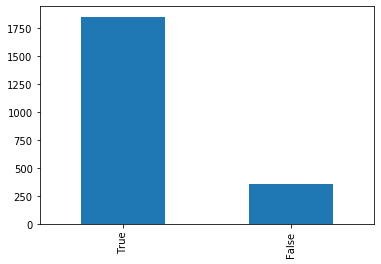

In [91]:
dg.target.value_counts().plot.bar()

In [34]:
X = pd.concat([dg.pastValues.apply(lambda x:pd.Series(x)), dg.currentValue, dg.target], axis=1)
y = X.pop('target')

In [35]:
# rescaling the dataframe
X = X.div(X.currentValue, axis=0)
X.drop(columns='currentValue')

,0,1,2,3,4
DateTime,,,,,
2019-09-13 13:35:00,1.000775,1.000916,1.000916,1.000423,1.000563
2019-09-13 13:36:00,1.000845,1.000845,1.000352,1.000493,0.999930
2019-09-13 13:37:00,1.001057,1.000563,1.000704,1.000141,1.000211
2019-09-13 13:38:00,1.000423,1.000563,1.000000,1.000070,0.999859
2019-09-13 13:39:00,1.000634,1.000070,1.000141,0.999930,1.000070
...,...,...,...,...,...
2019-12-27 15:50:00,1.000444,1.000481,1.000444,1.000591,1.000000
2019-12-27 15:51:00,1.000777,1.000740,1.000887,1.000296,1.000296
2019-12-27 15:52:00,1.000592,1.000739,1.000148,1.000148,0.999852


## A precision recall-curve with only one training split.

In [36]:
# temporal split of train/test
trainPercentage = 20
testBegins = (len(X)*trainPercentage)//100
Xtrain, ytrain = X[:testBegins], y[:testBegins]
Xtest, ytest = X[testBegins:], y[testBegins:]

In [37]:
parameters = {
    'min_samples_leaf' : [10, 20, 100],
    'max_depth': [5, 10, 20],
    'n_estimators': [10, 20, 100],   
    'max_features': ['sqrt']
}

regr = RandomForestClassifier(class_weight='balanced')
grid = GridSearchCV(regr, parameters, cv=2, scoring='average_precision')

In [38]:
grid.fit(Xtrain, ytrain)
model = grid.best_estimator_

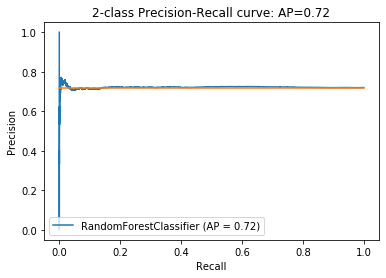

In [39]:
base_rate = sum(ytest)/len(ytest)
ypredicted=model.predict_proba(Xtest)[:,1]
average_precision = average_precision_score(ytest, ypredicted)
disp = plot_precision_recall_curve(model, Xtest, ytest)
disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.plot([0, 1], [base_rate, base_rate]);

# A precision-recall curve with multiple training batches

In [20]:
X = pd.concat([dg.pastValues.apply(lambda x:pd.Series(x)), dg.currentValue, dg.target], axis=1)
firstTimeStamp=X.index[0]
first_day = datetime(firstTimeStamp.year, firstTimeStamp.month, firstTimeStamp.day)
X['week']=pd.Series(X.index).apply(lambda x: (datetime(x.year, x.month, x.day)-first_day).days//7).values

In [21]:
# notice that for the week zero we wont have a model.
trainSets = [X[X.week==w] for w in X.week.unique()]
trainTestBarches = [(None, None, None, None)]+[(trainSets[i].drop(columns='target'),trainSets[i].target,trainSets[i+1].drop(columns='target'),trainSets[i+1].target) for i in range(len(trainSets)-1)]
models = [None] + [GridSearchCV(regr, parameters, cv=2, scoring='average_precision') for _ in range(len(trainSets)-1)]

In [22]:
Xtrain, ytrain, Xtest, ytest = trainTestBarches[1]

In [23]:
Xtrain # notice: week should not be in the model, but its ok for now

,0,1,2,3,4,currentValue,week
DateTime,,,,,,,
2019-01-14 10:37:00,114.78,114.73,114.92,114.92,114.86,114.89,0
2019-01-14 10:38:00,114.73,114.92,114.92,114.86,114.89,114.86,0
2019-01-14 10:39:00,114.92,114.92,114.86,114.89,114.86,114.84,0
2019-01-14 10:40:00,114.92,114.86,114.89,114.86,114.84,114.81,0
2019-01-14 10:41:00,114.86,114.89,114.86,114.84,114.81,114.81,0
...,...,...,...,...,...,...,...
2019-01-18 15:52:00,118.13,118.12,118.14,118.13,118.09,118.02,0
2019-01-18 15:53:00,118.12,118.14,118.13,118.09,118.02,118.02,0
2019-01-18 15:54:00,118.14,118.13,118.09,118.02,118.02,118.03,0


In [24]:
for i in range(1, len(models)):
    print(i)
    Xtrain, ytrain, Xtest, ytest = trainTestBarches[i]
    models[i].fit(Xtrain.div(Xtrain.currentValue, axis=0), ytrain)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [ ]:
# this function is worth saving somewhere !
def indexedModelEvaluation(x):
    row = x.copy()
    week = row['week']
    row = row.drop('target')
    row = [list(row/row.currentValue)]
    model = models[week]
    return np.nan if model==None else model.predict_proba(row)[0][1]

In [ ]:
ypredicted = X.apply(indexedModelEvaluation,axis=1)

In [ ]:
X['predicted']=ypredicted

In [ ]:
dh = X[['predicted', 'target']].copy()

In [ ]:
dh = dh[dh.predicted.notna()] 

In [ ]:
ytest = dh.target
ypredicted = dh.predicted
base_rate = sum(ytest)/len(ytest)
average_precision = average_precision_score(ytest, ypredicted)
precision, recall, _ = precision_recall_curve(ytest, ypredicted)

In [ ]:
plt.plot(recall, precision)
plt.plot([0, 1], [base_rate, base_rate]);